In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from patsy import dmatrix, build_design_matrices
from scipy.stats import multivariate_normal
from itertools import cycle
from scipy.optimize import curve_fit
from tqdm import tqdm
import re

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
milk_data_OG = pd.read_csv('../Data/TheData.csv')
milk_data_OG['DateTime'] = pd.to_datetime(milk_data_OG['DateTime'], errors='coerce')
milk_data_OG['StartTime'] = pd.to_datetime(milk_data_OG['StartTime'], format='%H:%M:%S', errors='coerce').dt.time
milk_data_OG['StartDate'] = pd.to_datetime(milk_data_OG['StartDate'], errors='coerce')

In [3]:
milk_data = milk_data_OG.copy()
milk_data = milk_data[(milk_data['FarmName_Pseudo'] == 'a624fb9a') | (milk_data['FarmName_Pseudo']=='f454e660')]
DATA = milk_data[['DateTime', 'StartDate', 'SE_Number','FarmName_Pseudo','TotalYield', 'HW', 'cum_HW', 'DaysInMilk', 'LactationNumber','BreedName', 'Temperature', 'Relative Humidity', 'THI_adj']]


### Calculate daily records

In [29]:
agg_functions = {
    'TotalYield': 'sum', # Daily sum of all the yields. Can be replaced with 'mean' to get daily mean instead
    'HW': 'first', # Since the HW indicator will be the same for all instances of the same day (given the same farm), we save the 'first'
    'cum_HW': 'first', # Same as for 'HW'
    'DaysInMilk': 'first', # Same as for 'HW'
    'LactationNumber': 'first', # Same as for 'HW'
    'BreedName': 'first', # It will be the same cow, so we save first instance of 'BreedName'
    'Temperature': ['mean', 'max', 'min'], #Save both the daily Max temperature as well as daily mean temperature
    'Relative Humidity': 'mean', # Save daily mean humidity
    'THI_adj': 'mean', # save daily mean THI-adjusted
    'FarmName_Pseudo': 'first'

}
daily_data = DATA.groupby(['SE_Number', 'StartDate']).agg(agg_functions).reset_index() #Group by day (StartDate)

# Remove the weird 'first' prefixes from the column names
daily_data.columns = [' '.join(col).strip() if 'first' not in col[1] else col[0] for col in daily_data.columns.values] 

# rename the columns to approiate prefixes
daily_data = daily_data.rename(columns={
    'TotalYield sum': 'DailyTotalYield',
    'DaysInMilk first': 'DaysInMilk',
    'Temperature mean': 'MeanTemperature',
    'Temperature max': 'MaxTemperature',
    'Temperature min' : 'MinTemperature',
    'Relative Humidity mean': 'MeanRelHumidity',
    'THI_adj mean': 'MeanTHI_adj',
    'FarmName_Pseudo first' : 'FarmName_Pseudo'
})


### Normalizing by Wood's Lactation Cycle

In [30]:

# Define the Wood's Lactation Curve function
def woods_lactation_curve(dim, a, b, c):
    dim = np.array(dim, dtype=float)
    return a * dim**b * np.exp(-c * dim)

# Function to fit the Wood's Lactation Curve to the dataset
def fit_woods_lactation_curve(dataset):
    # Initialize the 'ExpectedYield' column to NaN
    dataset['ExpectedYield'] = np.nan
    
    # Group the dataset by 'SE_Number' and fit the curve for each cow
    for animal_number, group in tqdm(dataset.groupby('SE_Number'), unit= " Cows"):
        # Prepare the data for fitting
        x_data = group['DaysInMilk']
        y_data = group['DailyTotalYield']
        
        # Fit the model
        try:
            # Initial parameter guesses
            initial_guesses = [max(y_data), 0.4, 0.0001]
            # Bounds on the parameters to prevent overflow
            bounds = ([0, 0, 0], [np.inf, 1, 0.1])
            popt, pcov = curve_fit(
                woods_lactation_curve, x_data, y_data,
                p0=initial_guesses, bounds=bounds, maxfev=10000
            )
            
            # Predict the expected yield using the fitted model
            group['ExpectedYield'] = woods_lactation_curve(group['DaysInMilk'], *popt)
            
            # Normalize the DailyTotalYield
            group['NormalizedDailyTotalYield'] = group['DailyTotalYield'] / group['ExpectedYield']
            
            # Update the dataset with the fitted data
            dataset.loc[group.index, 'ExpectedYield'] = group['ExpectedYield']
            dataset.loc[group.index, 'NormalizedDailyTotalYield'] = group['NormalizedDailyTotalYield']
            
        except RuntimeError as e:
            print(f"Curve fit failed for cow {animal_number}: {e}")
    
    # Fill any NaN values in the newly created columns with 0
    dataset['ExpectedYield'].fillna(0, inplace=True)
    dataset['NormalizedDailyTotalYield'].fillna(0, inplace=True)
    
    return dataset

daily_data = fit_woods_lactation_curve(daily_data)
daily_data.head()

  1%|          | 4/376 [00:00<00:10, 36.52 Cows/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 99%|█████████▊| 371/376 [00:07<00:00, 43.20 Cows/s]c:\Users\axele\.conda\envs\Doris\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 376/376 [00:07<00:00, 48.86 Cows/s]


,SE_Number,StartDate,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,BreedName,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,FarmName_Pseudo,ExpectedYield,NormalizedDailyTotalYield
0,SE-064c0cec-1189,2022-01-01,30.77,0,0.0,191.0,7,02 SLB,-3.150000,-2.3,-4.0,92.900000,-1587.361000,a624fb9a,29.739372,1.034655
1,SE-064c0cec-1189,2022-01-02,48.22,0,0.0,192.0,7,02 SLB,-0.500000,0.3,-2.1,99.033333,-1428.221600,a624fb9a,29.692059,1.624003
2,SE-064c0cec-1189,2022-01-03,30.53,0,0.0,193.0,7,02 SLB,2.600000,2.9,2.3,97.300000,-1098.689840,a624fb9a,29.644756,1.029862
3,SE-064c0cec-1189,2022-01-04,42.26,0,0.0,194.0,7,02 SLB,-0.466667,-0.1,-1.1,93.300000,-1339.335013,a624fb9a,29.597463,1.427825
4,SE-064c0cec-1189,2022-01-05,38.49,0,0.0,195.0,7,02 SLB,-3.900000,-0.9,-5.9,87.133333,-1533.761680,a624fb9a,29.550181,1.302530


In [31]:
# Print the top 10 cows with the most records: 
daily_data.value_counts('SE_Number')[:10]

SE_Number
SE-a624fb9a-1265    630
SE-a624fb9a-1297    627
SE-f454e660-0622    626
SE-f454e660-0650    623
SE-f454e660-0157    623
SE-a624fb9a-1261    622
SE-a624fb9a-1359    621
SE-a624fb9a-1410    620
SE-a624fb9a-1212    619
SE-f454e660-0610    618
Name: count, dtype: int64

### Select cow by adjusting below variable name

Pick from one of the top cows with the most records


In [32]:
subject_type = 'farm'  # Adjust here to 'farm' if needed
cow_id = 'SE-a624fb9a-1261' #Adjust here for specific cow
farm_id = 'f454e660' #adjust here for specific farm
subject_id =  cow_id if subject_type == 'cow' else farm_id


data = daily_data[daily_data['SE_Number' if subject_type == 'cow' else 'FarmName_Pseudo'] == subject_id].copy()

print(f"The daily records dataframe for {subject_id} ({subject_type}) has {data.shape[0]} entries and {data.shape[1]} columns")
data.head()

The daily records dataframe for f454e660 (farm) has 84007 entries and 16 columns


,SE_Number,StartDate,DailyTotalYield,HW,cum_HW,DaysInMilk,LactationNumber,BreedName,MeanTemperature,MaxTemperature,MinTemperature,MeanRelHumidity,MeanTHI_adj,FarmName_Pseudo,ExpectedYield,NormalizedDailyTotalYield
1571,SE-7fd04cd3-679,2022-01-01,12.93,0,0.0,339.0,4,04 SJB,1.2,1.2,1.2,81.700000,-1031.670280,f454e660,13.574447,0.952525
1572,SE-7fd04cd3-679,2022-01-02,13.72,0,0.0,340.0,4,04 SJB,4.9,4.9,4.9,99.000000,-892.587600,f454e660,13.614490,1.007750
1573,SE-7fd04cd3-679,2022-01-03,14.19,0,0.0,341.0,4,04 SJB,4.7,4.7,4.7,94.800000,-874.350960,f454e660,13.654533,1.039215
1574,SE-a2bab923-0680,2022-01-01,36.88,0,0.0,70.0,8,04 SJB,2.2,5.1,0.3,87.866667,-1016.724893,f454e660,29.875932,1.234438
1575,SE-a2bab923-0680,2022-01-02,19.70,0,0.0,71.0,8,04 SJB,5.3,5.7,4.9,99.050000,-851.137800,f454e660,29.853454,0.659890


### Downsampling

Too further process the data, we bin the data into $N$ number of temperature bins, then we calculate the mean for each bin. Giving us $N$ datapoints.

In [39]:
N = 200
input_feature_label = 'MeanTHI_adj'

bins = pd.cut(data[input_feature_label], bins=N) 
bin_midpoints = bins.apply(lambda x: x.mid)
mean_yields = data.groupby(bin_midpoints, observed=True)['NormalizedDailyTotalYield'].mean().reset_index()

# Assign target y and input vector x:
x = mean_yields[input_feature_label].values
y = mean_yields.NormalizedDailyTotalYield.values

## Bayesian linear regression with Splines

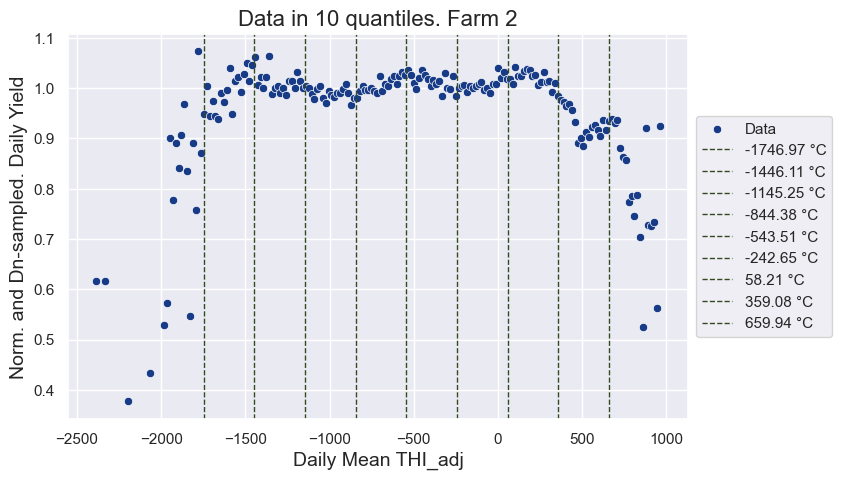

In [69]:
# Divide the data into 'num_qs' number of quantiles
num_qs = 10

knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

knot_group = np.digitize(x, knot_list)
knot_group = pd.Categorical(knot_group, ordered=True)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
legend_texts = []
scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax = ax)

for knot in knot_list:
    line = ax.axvline(knot, color='#354A21', linestyle='--', linewidth=1, label=f"{knot:.2f} °C")
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"Data in {num_qs} quantiles. Farm 2", fontsize =16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize  = 14)
plt.ylabel('Norm. and Dn-sampled. Daily Yield', fontsize  = 14)

plt.show()
#plt.savefig(rf'binned_Bsplines.png')


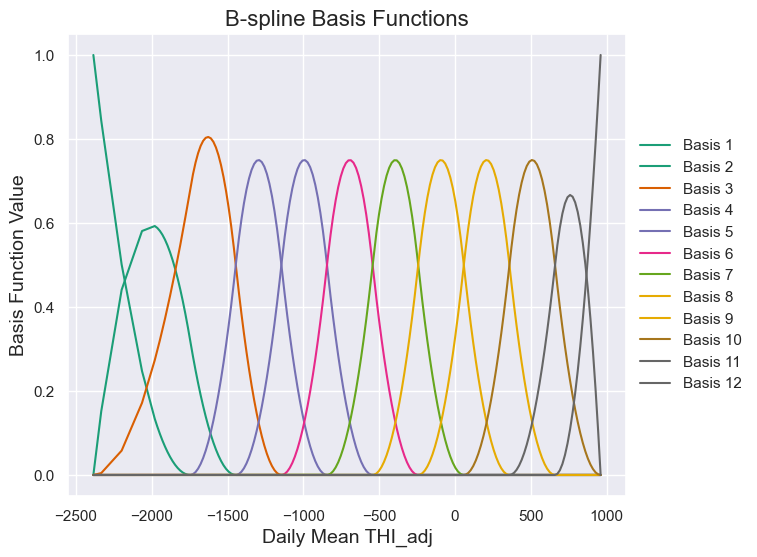

In [102]:
def Phi(a, knots, degree=3, spline_type = 'B'):
    if spline_type == 'B':
        # Create a design matrix using B-spline basis functions
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots}) #[:-1]
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots = knots, constraints='center')- 1", {"x": a, 'knots': knots}) #
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B

degree_spline = 2 # <---- change order of polynomial here
B = Phi(x, knots=knot_list, degree=degree_spline, spline_type = 'B')
color = cycle(cm.Dark2(np.linspace(0, 1, B.shape[1])))
#color = cycle(viridis(np.linspace(0, 1, B.shape[1])))
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
legend_texts = [] 
for i in range(B.shape[1]):
    c = next(color)
    line, = ax.plot(x, B[:, i], c = c, label=f'Basis {i + 1}')

plt.title('B-spline Basis Functions', fontsize= 16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize= 14)
plt.ylabel('Basis Function Value', fontsize= 14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.show()
#plt.savefig(rf'basis_{degree_spline}_Bsplines.png', format='png', transparent=True)


In [103]:
# Define the prior on the weights
# p(w) = N(w; m0, S0)
D = B.shape[1]
m0 = np.zeros(D)
S0 = np.eye(D) #/D

beta = 1/np.var(y)

# Compute the posterior distribution of the Bayesian linear regression model
# p(w | y) = N(w; mN, SN). Check paper for more info
SN = np.linalg.inv(np.linalg.inv(S0) + beta * B.T @ B)
mN = SN @ (np.linalg.inv(S0) @ m0 + beta * B.T @ y)

print(f"Posterior of coefficents. {subject_type} {subject_id}")
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN)**2)
print(f"{mse:.4f}")


Posterior of coefficents. farm f454e660
Mean squared error is... 0.0035


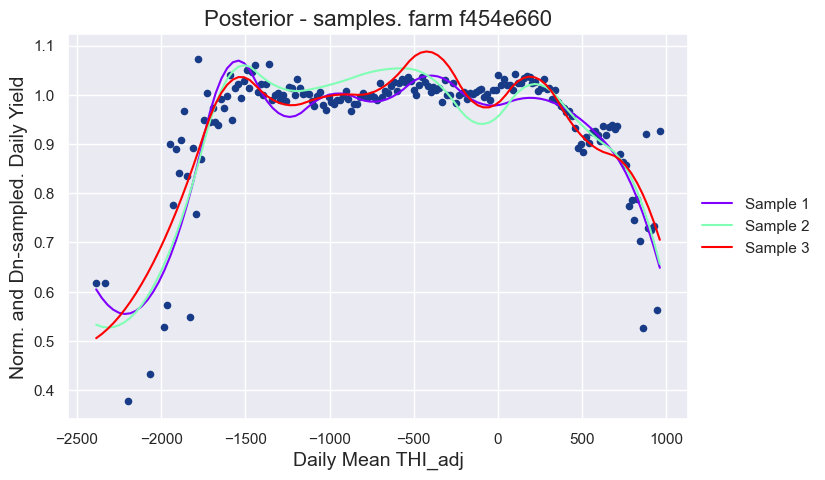

In [104]:

# Visualize the posterior p(w | y) = N(w; mN, SN)
# Draw samples of the weights from the posterior
samples = 3
seed = 100
ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

n = 100  # number of grid-points
xs = np.linspace(x.min(), x.max(), n)
new_data = {'x': xs}

B_star = build_design_matrices([B.design_info], new_data)[0]
B_star = np.asarray(B_star)

# Compute corresponding values f(x*)
fs = B_star @ ws.T

# Plot the samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color ='#183B87', zorder=1, s=20)
color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
#color = cycle(['#BF0A30', '#00BAFF','#B8AE09' ])
for i in range(ws.shape[0]):
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c = c, label = f"Sample {i+1}") # samples

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'Posterior - samples. {subject_type} {subject_id}', fontsize= 16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize= 14)
plt.ylabel('Norm. and Dn-sampled. Daily Yield', fontsize  = 14)

plt.show()

# plt.savefig(rf'{degree_spline}_basis_samples.png', transparent=True)

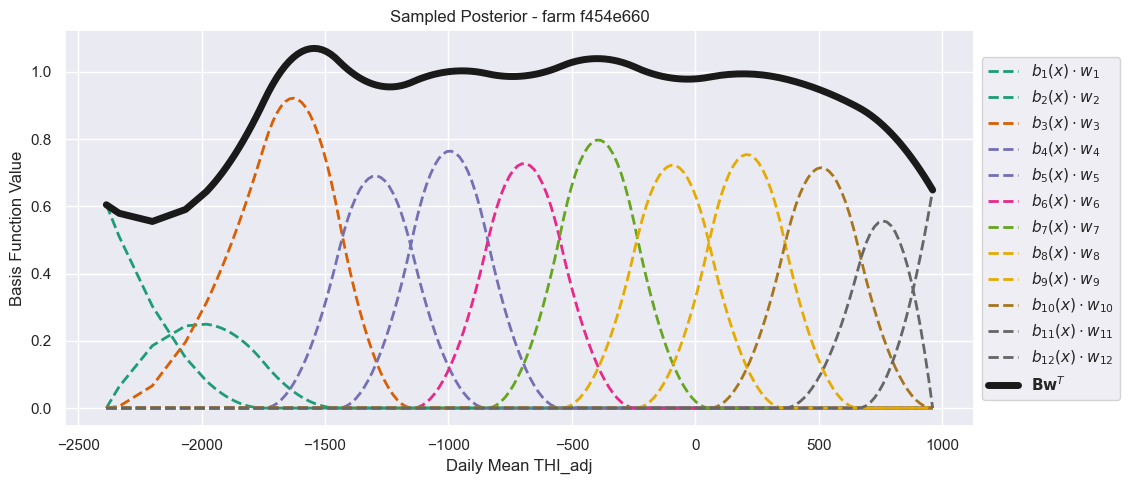

In [73]:
color = cycle(cm.Dark2(np.linspace(0, 1, B.shape[1])))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
BB = B
for i in range(B.shape[1]):
    c = next(color)
    label = f'$b_{{{i+1}}}(x) \\cdot w_{{{i+1}}}$'
    ax.plot(x, ws[0][i]*B[:, i], linestyle='--', c=c, label=label, linewidth=2)

label_sum = '$\\mathbf{B} \\mathbf{w}^T$'
ax.plot(x, np.dot(ws[0], BB.T), color='k', linewidth=5, label=label_sum)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title(f'Sampled Posterior - {subject_type} {subject_id}')
ax.set_xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
ax.set_ylabel('Basis Function Value')

plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.gcf().set_edgecolor('none')

plt.show()

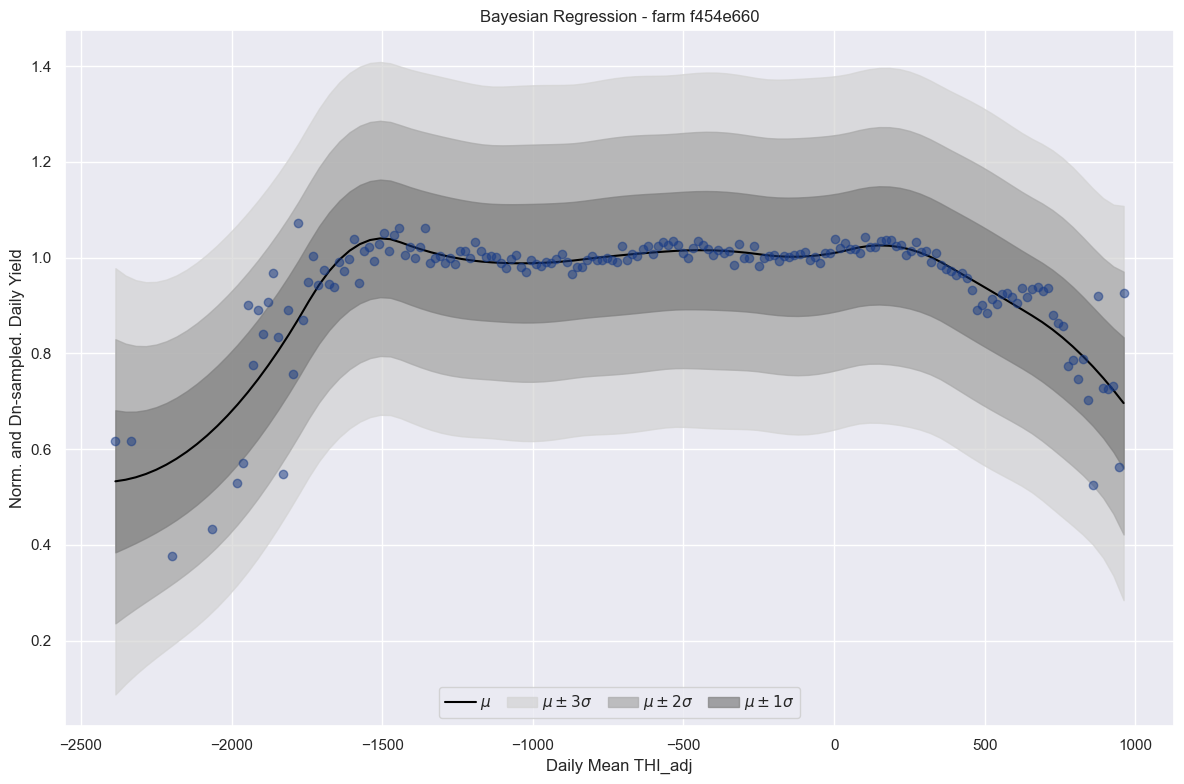

In [79]:

mstar = B_star @ mN
Sstar = B_star @ SN @ B_star.T + beta**(-1) * np.eye(n) #B_star.shape[0]

# Extract standard deviation of predictive distribution
stdpred = np.sqrt(np.diag(Sstar))

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar, 'black', label = f'$\mu$') # predictive mean
line = plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray', alpha = 0.7, label = f'$\mu \pm 3\\sigma$')
line = plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray', alpha = 0.7, label = f'$\mu \pm 2\\sigma$')
line = plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray', alpha = 0.7, label = f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha = 0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, columnspacing=1, handletextpad=0.3)
plt.title(f'Bayesian Regression - {subject_type} {subject_id}')
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Norm. and Dn-sampled. Daily Yield')
plt.grid(True)
plt.tight_layout()
plt.show()
#plt.savefig('lin_basis_uncert.svg', format='svg', transparent=True)

Try assigning likelihood hyperparameter from previous model

In [80]:
residuals = (y - B @ mN)**2  # Calculate residuals
beta_mle = 1 / np.var(residuals) # MLE estimate for beta

# Use the MLE estimate for beta in the subsequent Bayesian linear regression
SN_mle = np.linalg.inv(np.linalg.inv(S0) + beta_mle * B.T @ B)
mN_mle = SN_mle @ (np.linalg.inv(S0) @ m0 + beta_mle * B.T @ y)
print("Posterior of coefficents after MLE")
print("=-"*30)
print('Mean squared error is... ', end='')
mse = np.mean((y - B @ mN_mle)**2)
print(f"{mse:.3f}")

Posterior of coefficents after MLE
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Mean squared error is... 0.003


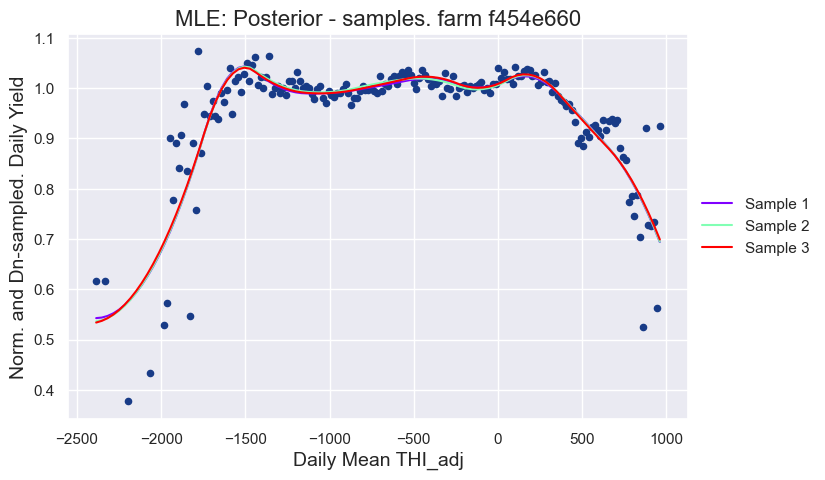

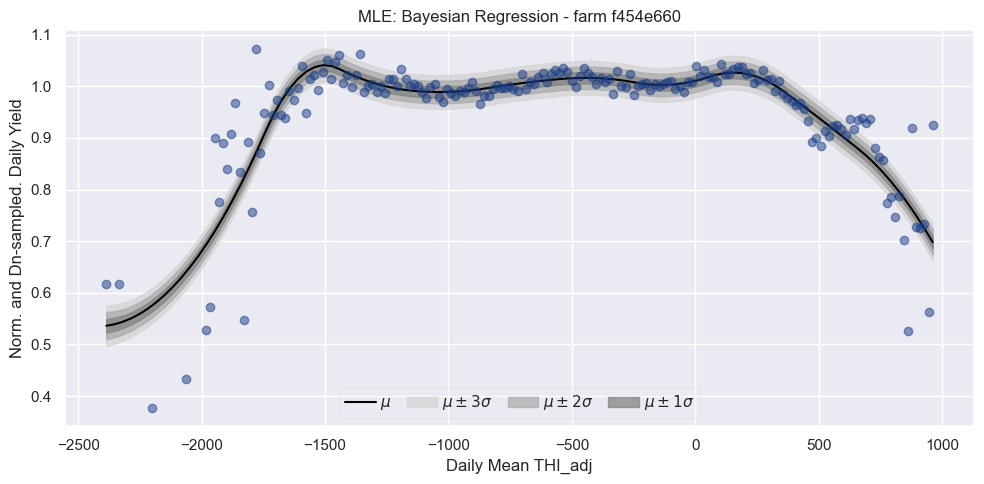

In [83]:
samples = 3
ws_mle = multivariate_normal(mean=mN_mle, cov=SN_mle, allow_singular=True).rvs(samples, random_state=seed)

n = 100  # number of grid-points
xs = np.linspace(x.min(), x.max(), n)
new_data = {'x': xs}
B_star = build_design_matrices([B.design_info], new_data)[0]
B_star = np.asarray(B_star)

fs_mle = B_star @ ws_mle.T

# Plot the samples
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, color ='#183B87', zorder=1, s=20)
color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(ws.shape[0]):
    c = next(color)
    line, = ax.plot(xs, fs_mle[:, i], c = c, label = f"Sample {i+1}") # samples

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

plt.title(f'MLE: Posterior - samples. {subject_type} {subject_id}', fontsize= 16)
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize= 14)
plt.ylabel('Norm. and Dn-sampled. Daily Yield', fontsize  = 14)
plt.grid(True)
plt.show()



mstar_mle = B_star @ mN_mle
Sstar_mle = B_star @ SN_mle @ B_star.T + beta_mle**(-1) * np.eye(B_star.shape[0])

stdpred_mle = np.sqrt(np.diag(Sstar_mle))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar_mle, 'black', label = f'$\mu$') # predictive mean
plt.fill_between(xs, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha = 0.7, label = f'$\mu \pm 3\\sigma$')
plt.fill_between(xs, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha = 0.7, label = f'$\mu \pm 2\\sigma$')
plt.fill_between(xs, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha = 0.7, label = f'$\mu \pm 1\\sigma$')

plt.scatter(x, y, c='#183B87', zorder=4, alpha = 0.5)

leg = ax.legend(loc='lower center', frameon=True, ncol=5, framealpha=0.2, columnspacing=1, handletextpad=0.3)

plt.title(f'MLE: Bayesian Regression - {subject_type} {subject_id}')
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Norm. and Dn-sampled. Daily Yield')
plt.grid(True)
plt.tight_layout()
plt.show()


Let's compare with classical Least Squares Error linear regression

Difference in parameter from LSE and mean from Bayes is 0.012894468669751635


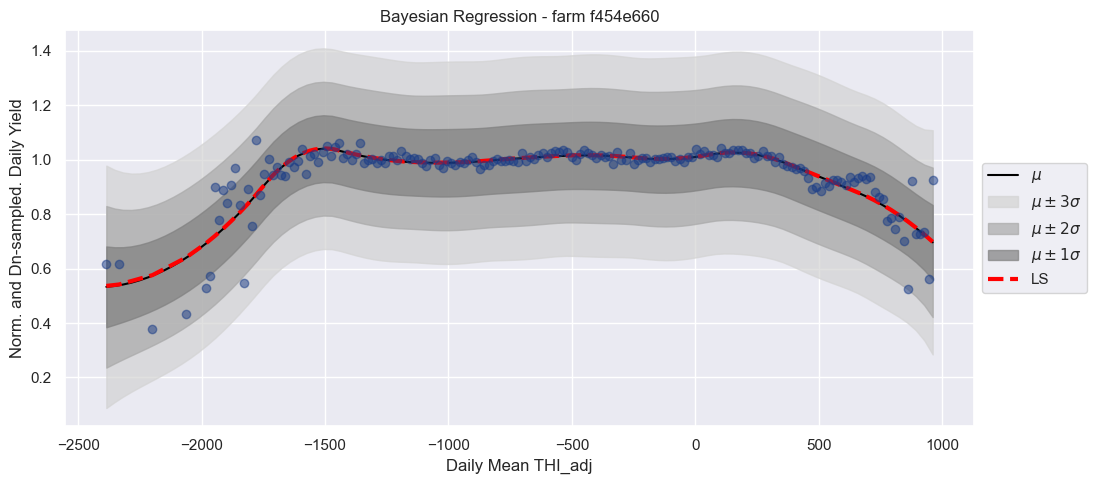

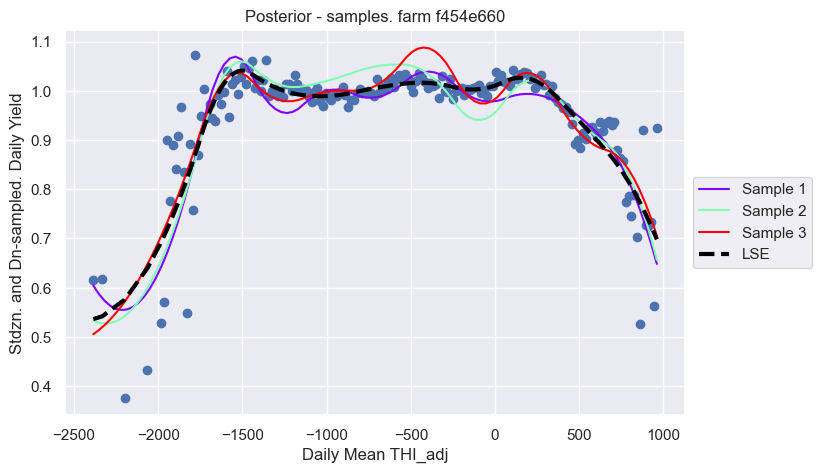

In [95]:
stdpred = np.sqrt(np.diag(Sstar))

theta = np.dot(np.linalg.inv(np.dot(B.T, B)), np.dot(B.T, y)) #LSE
y_MLE = B @ theta.T
print(f"Difference in parameter from LSE and mean from Bayes is {np.sum(theta - mN)}")

#plot
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
line, = plt.plot(xs, mstar, 'black', label = f'$\mu$') # predictive mean
plt.fill_between(xs, mstar + 3*stdpred, mstar - 3*stdpred, color='lightgray', alpha = 0.7, label = f'$\mu \pm 3\\sigma$')
plt.fill_between(xs, mstar + 2*stdpred, mstar - 2*stdpred, color='darkgray', alpha = 0.7, label = f'$\mu \pm 2\\sigma$')
plt.fill_between(xs, mstar + 1*stdpred, mstar - 1*stdpred, color='gray', alpha = 0.7, label = f'$\mu \pm 1\\sigma$')
line2, = plt.plot(x, y_MLE, 'red', linewidth=3, linestyle='--', label='LS')
plt.scatter(x, y, zorder=4, alpha = 0.5, c='#183B87')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'Bayesian Regression - {subject_type} {subject_id}')
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Norm. and Dn-sampled. Daily Yield')

plt.tight_layout()
plt.show()


#plot
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.scatter(x, y, zorder=1)
color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
for i in range(ws.shape[0]):
    c = next(color)
    line, = ax.plot(xs, fs[:, i], c = c, label = f"Sample {i+1}") # samples
line2, = plt.plot(x, y_MLE, 'black', linewidth=3, linestyle='--', label='LSE')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(f'Posterior - samples. {subject_type} {subject_id}')
plt.xlabel('Daily '+ re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label))
plt.ylabel('Stdzn. and Dn-sampled. Daily Yield')

plt.show()